<a href="https://colab.research.google.com/github/TobiasSunderdiek/hyperparameter-tuning-with-tune/blob/master/predicting_bike_sharing_data_with_tune_for_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting bike sharing data with tune for hyperparameter tuning


This notebook is based on the udacity deep learning nanodegree project for predicting bike sharing data, which can be found here:

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-bikesharing/Predicting_bike_sharing_data.ipynb

I use the udacity implementation as a starting point for a self-learning project in which I try to build a variation where the model is a fcn and the hyperparameter tuning is done with tune[1].

[1] https://ray.readthedocs.io/en/latest/tune.html

## Prepare for using tune
For use in colab, pyarrow has to be uninstalled. After that, colab runtime has be be restarted.

Additionally, clean-up log dir for tune logs.

In [1]:
# preparing for using tune
!pip install ray
!pip uninstall -y pyarrow
# cleanup tune log dir if exists
!rm -rf tune_logs

## Loading dataset from github
The original dataset is located here:

https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-bikesharing/Bike-Sharing-Dataset/hour.csv

which originaly came from [1].

[1] Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

In [2]:
# Fetch a single file using the raw GitHub URL.
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-bikesharing/Bike-Sharing-Dataset/hour.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1129k  100 1129k    0     0  3586k      0 --:--:-- --:--:-- --:--:-- 3574k


In [3]:
import pandas as pd

rides = pd.read_csv("/content/hour.csv")
rides_origin = rides
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Convert data
- hot-encode categorical features *season*, *weathersit*, *mnth*, *hr*, *weekday* and drop origin of this features
- drop fields *instant*, *dteday*, *atemp* and *workingday* as in the udacity project
- additionally drop fields *casual* and *registered*, focus on overall output *cnt*
- shift and scale continuous features *cnt*, *temp*, *hum*, *windspeed* so they have zero mean and standard deviation of 1

In [4]:
for feature in ['season', 'weathersit', 'mnth', 'hr', 'weekday']:
  hot_encoded_features = pd.get_dummies(rides[feature], prefix=feature, drop_first=False)
  rides = pd.concat([rides, hot_encoded_features], axis=1)
  rides = rides.drop(feature, axis=1)
rides = rides.drop(['instant', 'dteday', 'atemp', 'workingday', 'casual', 'registered'], axis=1)

feature_scaling_store = {}

for feature in ['cnt', 'temp', 'hum', 'windspeed']:
  mean, std = rides[feature].mean(), rides[feature].std()
  feature_scaling_store[feature] = [mean, std]
  rides.loc[:, feature] = (rides[feature] - mean) / std

rides.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Split into training,  testing and validation set
The data consists of entries of how many bikes are rented at one specific hour of the day. The total number of entries in the hour.csv is 17.379, which means divided by 24 there are datapoints for approximatly 724 days.

The last 21 days (3%) are used as testing data.

Of the remaining days, 60 days (8.5%) are used as validation data.

The training data consists of 643 days.

In [0]:
test_data = rides[-21*24:]
rides = rides[:-21*24]

validation_data = rides[-60*24:]
rides = rides[:-60*24]

train_data = rides

target_fields = ['cnt']

features_train, targets_train = train_data.drop(target_fields, axis=1), train_data[target_fields]
features_validation, targets_validation = validation_data.drop(target_fields, axis=1), validation_data[target_fields]
features_test, targets_test = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [0]:
import torch

from torch.utils.data import TensorDataset

train_set = TensorDataset(torch.tensor(features_train.values).double(),
                          torch.tensor(targets_train.values).double())

valid_set = TensorDataset(torch.tensor(features_validation.values).double(),
                          torch.tensor(targets_validation.values).double())

## Network architecture
I define the necessary parts of the architecture and try them out before handing over to tune.

### Hyperparameter

defined as map in `hyperparameter`, e.g.:

 `hyperparameter = {'learning_rate': 0.01, 'hidden_nodes': 25, 'epochs': 4000, 'batch_size': 1}`

### Model

Model has same architecture as in the udacity model, especially:
- no bias is added to the layers instead of using automatic bias initialization from pytorch with uniform distribution
- tensors are in double tensors
- weights initialization is changed to normal distribution in range of 0.0 to input_nodes**-0.5 instead of using automatic weight initialization from pytorch with uniform distribution

Size of input node is equal to columns in feature data
```
input_nodes = features_train.shape[1]

bikeSharingModel = BikeSharingModel(input_nodes, hyperparameter['hidden_nodes'])
```

which results in e.g. (depends on hyperparameter hidden_nodes)

```
BikeSharingModel(
    (fc_1): Linear(in_features=56, out_features=25, bias=True)
    (fc_2): Linear(in_features=25, out_features=1, bias=True)
)
```


In [0]:
from torch import nn

class BikeSharingModel(nn.Module):
  def __init__(self, input_nodes, hidden_nodes):
    super(BikeSharingModel, self).__init__()
    self.fc_1 = nn.Linear(input_nodes, hidden_nodes, bias=False).double()
    self.fc_2 = nn.Linear(hidden_nodes, 1, bias=False).double()
 
  def forward(self, x):
    x = self.fc_1(x)
    x = torch.sigmoid(x)
    x = self.fc_2(x)
 
    return x

def init_weights(m):
  if type(m) == nn.Linear:
    m.weight.data.normal_(0, m.in_features ** -0.5)


### Loss-function

MSE is used as loss function

In [0]:
criterion = nn.MSELoss()

### Optimizer
To first get a result which is similar to the udacity project, I choose SGD as optimizer.

```
optimizer = optim.SGD(bikeSharingModel.parameters(), lr=hyperparameter['learning_rate'])
```

## Train, validate and test/inference
Training is done with a batch size of random training data. Batch size is configured within `hyperparameter['batch_size']`.

In [9]:
# check gpu
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  print("Train on GPU")
else:
  print("Train on CPU")

Train on GPU


In [0]:
import matplotlib.pyplot as plt

def plot(train_losses, validation_losses):
  plt.plot(train_losses, label='Training loss')
  plt.plot(validation_losses, label='Validation loss')
  plt.legend()
  _ = plt.ylim(0, 0.75)

In [0]:
import numpy as np
import sys
from ray import tune
from torch import optim
from torch.utils.data import DataLoader

def train_validate_with_tune_tracking(train_set, valid_set, hyperparameter, with_tune_tracking=False):

  train_loader = DataLoader(train_set, shuffle=True, batch_size=hyperparameter['batch_size'])
  valid_loader = DataLoader(valid_set, shuffle=True, batch_size=hyperparameter['batch_size'])
  input_nodes = iter(train_loader).next()[0].shape[1]
  bikeSharingModel = BikeSharingModel(input_nodes, hyperparameter['hidden_nodes'])
  bikeSharingModel.apply(init_weights)
  optimizer = optim.SGD(bikeSharingModel.parameters(), lr=hyperparameter['learning_rate'])
  
  if train_on_gpu:
    bikeSharingModel.cuda()

  train_losses, validation_losses = [], []
  for epoch in range(1, hyperparameter['epochs']+1):
    
    features_batch, targets_batch = iter(train_loader).next() # train with one batch only to get similar results to implementation without pytorch

    if train_on_gpu:
      features_batch, targets_batch = features_batch.cuda(), targets_batch.cuda()

    optimizer.zero_grad()

    output = bikeSharingModel(features_batch)

    loss = criterion(output, targets_batch)

    loss.backward()

    optimizer.step()

    train_losses.append(loss.item())

    # validate
    loss_validation = 0.0

    with torch.no_grad():
      bikeSharingModel.eval()
      for features_valid, targets_valid in valid_loader:

        if train_on_gpu:
          features_valid, targets_valid = features_valid.cuda(), targets_valid.cuda()

        output_validation = bikeSharingModel(features_valid)
        loss_validation += criterion(output_validation, targets_valid).item()

    bikeSharingModel.train()

    loss_validation = loss_validation / (len(valid_loader.dataset) / hyperparameter['batch_size'])
    validation_losses.append(loss_validation)

    # log results
    if with_tune_tracking:
      tune.track.log(validation_loss_metric=loss_validation)
    else:
      sys.stdout.write("\rProgress: {:2.1f}% Training loss: {:2.3f} Validation loss: {:2.3f} ".format(100*epoch/(hyperparameter['epochs']+1), loss, loss_validation))
      sys.stdout.flush()

  if not with_tune_tracking:
    plot(train_losses, validation_losses)

  return bikeSharingModel

In [0]:
def test(model_to_test, features, targets):

  with torch.no_grad():
    model_to_test.eval()
    if train_on_gpu:
      features, targets = features.cuda(), targets.cuda()
      
    output = model_to_test(features)
    test_loss = criterion(output, targets)
    model_to_test.train()

    print("\nTest loss ", test_loss.item())

    fig, ax = plt.subplots(figsize=(8,4))
    mean, std = feature_scaling_store['cnt']
    ax.plot(output.cpu().numpy()*std + mean, label='Prediction')
    ax.plot((targets_test['cnt']*std + mean).values, label='Data')
    ax.set_xlim(right=len(output))
    ax.legend()
    dates = pd.to_datetime(rides_origin.iloc[test_data.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    ax.set_xticks(np.arange(len(dates))[12::24])
    _ = ax.set_xticklabels(dates[12::24], rotation=45)

## Manual hyperparameter tuning

Progress: 100.0% Training loss: 0.556 Validation loss: 1.268 
Test loss  0.3994219372001323


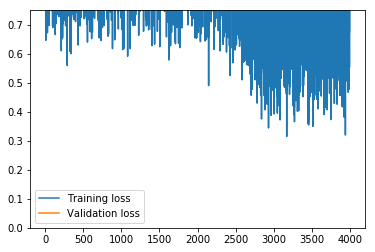

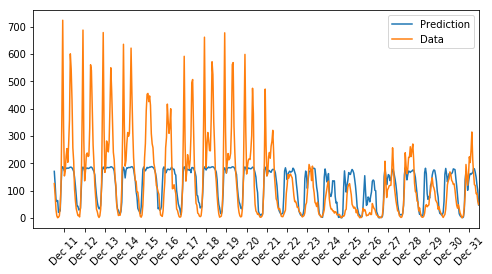

In [13]:
hyperparameter = {'learning_rate': 0.5, 'hidden_nodes': 25, 'epochs': 4000, 'batch_size': 128}

trained_model = train_validate_with_tune_tracking(train_set, valid_set, hyperparameter)
test(trained_model, torch.tensor(features_test.values).double(), torch.tensor(targets_test.values).double())

Result looks not similar to the model build in the udacity project.

Progress: 100.0% Training loss: 0.348 Validation loss: 0.596 
Test loss  0.2945723896368543


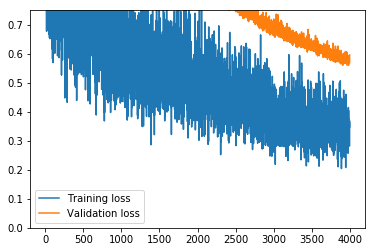

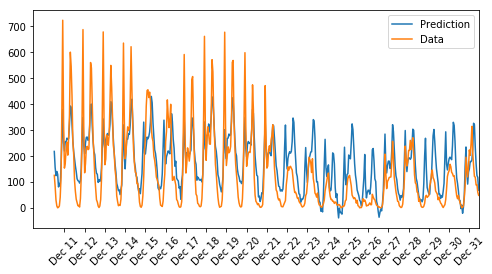

In [14]:
# try other hyperparameter
hyperparameter = {'learning_rate': 0.01, 'hidden_nodes': 25, 'epochs': 4000, 'batch_size': 128}

trained_model = train_validate_with_tune_tracking(train_set, valid_set, hyperparameter)
test(trained_model, torch.tensor(features_test.values).double(), torch.tensor(targets_test.values).double())

## Hyperparamter tuning with tune

In [15]:
!pip uninstall -y albumentations
!pip install --upgrade git+git://github.com/hyperopt/hyperopt.git
!pip install setproctitle

  Cloning git://github.com/hyperopt/hyperopt.git to /tmp/pip-req-build-pbasocui
  Running command git clone -q git://github.com/hyperopt/hyperopt.git /tmp/pip-req-build-pbasocui
  Running command git submodule update --init --recursive -q
  Created wheel for hyperopt: filename=hyperopt-0.1.2-cp36-none-any.whl size=115643 sha256=97f9436fc29d6ca339b2fdc387dbb6c1d0af25c76e0e09fc768807dab27935ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-d3bla4a_/wheels/c9/13/71/0d7783dc440af384cb42aff4d1f3b1ca565115fcda10588c9c
Successfully built hyperopt
  Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2


In [16]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from hyperopt import hp, tpe
from ray.tune.schedulers import ASHAScheduler

def tune_it(config):
  train_validate_with_tune_tracking(train_set, valid_set, config, with_tune_tracking=True)

search_space = {'learning_rate': hp.loguniform('learning_rate', 0.001, 0.5),
                'hidden_nodes': hp.choice('hidden_nodes', [10, 25, 30]),
                'batch_size': hp.choice('batch_size', [128, 256, 10, 1])
}

hyperopt = HyperOptSearch(search_space,
                          metric="validation_loss_metric",
                          mode="min")

tune_result = tune.run(tune_it,
                   config={'epochs': 4000},
                   local_dir='tune_logs',
                   verbose=0,
                   resources_per_trial={"cpu": 2, "gpu": 1},
                   search_alg=hyperopt,
                   num_samples = 5,
                   scheduler = ASHAScheduler(metric='validation_loss_metric', mode='min')
                   )

2019-09-06 21:46:11,608	INFO resource_spec.py:205 -- Starting Ray with 5.03 GiB memory available for workers and up to 2.53 GiB for objects. You can adjust these settings with ray.remote(memory=<bytes>, object_store_memory=<bytes>).
2019-09-06 21:46:12,333	INFO function_runner.py:254 -- tune.track signature detected.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/5.03 GiB heap, 0.0/1.71 GiB objects
Memory usage on this node: 2.1/12.7 GiB



2019-09-06 21:46:16,072	INFO logger.py:206 -- Initializing TFLogger instead of TF2Logger.
2019-09-06 21:46:16,125	WARNING util.py:144 -- The `start_trial` operation took 2.868037462234497 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/5.03 GiB heap, 0.0/1.71 GiB objects
Memory usage on this node: 2.2/12.7 GiB
Result logdir: /content/tune_logs/tune_it
Number of trials: 5 ({'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - tune_it_2_batch_size=1,epochs=4000,hidden_nodes=25,learning_rate=1.2158:	PENDING
 - tune_it_3_batch_size=1,epochs=4000,hidden_nodes=10,learning_rate=1.1396:	PENDING
 - tune_it_4_batch_size=1,epochs=4000,hidden_nodes=30,learning_rate=1.5828:	PENDING
 - tune_it_5_batch_size=10,epochs=4000,hidden_nodes=25,learning_rate=1.4051:	PENDING
RUNNING trials:
 - tune_it_1_batch_size=128,epochs=4000,hidden_nodes=10,learning_rate=1.2984:	RUNNING

Result for tune_it_1_batch_size=128,epochs=4000,hidden_nodes=10,learning_rate=1.2984:
  date: 2019-09-06_21-46-19
  done: false
  experiment_id: aa2560393bea487da0f37eb96fc6f78d
  hostname: 96d762

2019-09-06 21:46:21,920	INFO logger.py:206 -- Initializing TFLogger instead of TF2Logger.


Result for tune_it_1_batch_size=128,epochs=4000,hidden_nodes=10,learning_rate=1.2984:
  date: 2019-09-06_21-46-21
  done: true
  experiment_id: aa2560393bea487da0f37eb96fc6f78d
  hostname: 96d762a9cb60
  iterations_since_restore: 101
  node_ip: 172.28.0.2
  pid: 1420
  time_since_restore: 4.82602334022522
  time_this_iter_s: 0.022969484329223633
  time_total_s: 4.82602334022522
  timestamp: 1567806381
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: be9b34a2
  validation_loss_metric: 1.4806038001708441
  
Result for tune_it_2_batch_size=1,epochs=4000,hidden_nodes=25,learning_rate=1.2158:
  date: 2019-09-06_21-46-26
  done: false
  experiment_id: 16a02ae5f99f493d9a43a307cf046a0b
  hostname: 96d762a9cb60
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 1421
  time_since_restore: 3.066690444946289
  time_this_iter_s: 3.066690444946289
  time_total_s: 3.066690444946289
  timestamp: 1567806386
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: beb2f

2019-09-06 21:46:26,691	INFO logger.py:206 -- Initializing TFLogger instead of TF2Logger.


Result for tune_it_2_batch_size=1,epochs=4000,hidden_nodes=25,learning_rate=1.2158:
  date: 2019-09-06_21-46-26
  done: true
  experiment_id: 16a02ae5f99f493d9a43a307cf046a0b
  hostname: 96d762a9cb60
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  pid: 1421
  time_since_restore: 3.6301894187927246
  time_this_iter_s: 0.5634989738464355
  time_total_s: 3.6301894187927246
  timestamp: 1567806386
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: beb2f830
  validation_loss_metric: 10373.461739625245
  
== Status ==
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: -1.4571947700283272 | Iter 16.000: -1.4982475028293092 | Iter 4.000: -1.4820544205938218 | Iter 1.000: -2638.181076788399
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/5.03 GiB heap, 0.0/1.71 GiB objects
Memory usage on this node: 3.3/12.7 GiB
Result logdir: /content/tune_logs/tune_it
Number of trials: 5 ({'TERMINATED': 2, 'PENDING': 3})
PENDING trials:
 - tune_it_3_batch_size=1,epochs=4000,hidden_node

2019-09-06 21:46:33,641	INFO logger.py:206 -- Initializing TFLogger instead of TF2Logger.


Result for tune_it_3_batch_size=1,epochs=4000,hidden_nodes=10,learning_rate=1.1396:
  date: 2019-09-06_21-46-33
  done: true
  experiment_id: 2b7d19aca1c848a1bb17c3e34d720af7
  hostname: 96d762a9cb60
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  pid: 1467
  time_since_restore: 5.250328779220581
  time_this_iter_s: 0.546001672744751
  time_total_s: 5.250328779220581
  timestamp: 1567806393
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: beca6a1a
  validation_loss_metric: 9.774656994653025
  
Result for tune_it_4_batch_size=1,epochs=4000,hidden_nodes=30,learning_rate=1.5828:
  date: 2019-09-06_21-46-38
  done: false
  experiment_id: 899ca3e1faaf4a6db9e643814ef22519
  hostname: 96d762a9cb60
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 1480
  time_since_restore: 3.0397653579711914
  time_this_iter_s: 3.0397653579711914
  time_total_s: 3.0397653579711914
  timestamp: 1567806398
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: bedb9718
 

2019-09-06 21:46:39,018	INFO logger.py:206 -- Initializing TFLogger instead of TF2Logger.


Result for tune_it_4_batch_size=1,epochs=4000,hidden_nodes=30,learning_rate=1.5828:
  date: 2019-09-06_21-46-38
  done: true
  experiment_id: 899ca3e1faaf4a6db9e643814ef22519
  hostname: 96d762a9cb60
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  pid: 1480
  time_since_restore: 3.6087534427642822
  time_this_iter_s: 0.5689880847930908
  time_total_s: 3.6087534427642822
  timestamp: 1567806398
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bedb9718
  validation_loss_metric: 264984.99123194016
  


2019-09-06 21:46:43,306	INFO tune.py:269 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


Result for tune_it_5_batch_size=10,epochs=4000,hidden_nodes=25,learning_rate=1.4051:
  date: 2019-09-06_21-46-43
  done: false
  experiment_id: f3b21bf662854dfb9560a2f53be654bb
  hostname: 96d762a9cb60
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 1496
  time_since_restore: 2.5346381664276123
  time_this_iter_s: 2.5346381664276123
  time_total_s: 2.5346381664276123
  timestamp: 1567806403
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: bef19d56
  validation_loss_metric: 65.34771900233268
  
Result for tune_it_5_batch_size=10,epochs=4000,hidden_nodes=25,learning_rate=1.4051:
  date: 2019-09-06_21-46-43
  done: true
  experiment_id: f3b21bf662854dfb9560a2f53be654bb
  hostname: 96d762a9cb60
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  pid: 1496
  time_since_restore: 2.611325740814209
  time_this_iter_s: 0.07668757438659668
  time_total_s: 2.611325740814209
  timestamp: 1567806403
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bef19d

## Tune result

In [29]:
print("Best config: ", tune_result.get_best_config(metric='validation_loss_metric'))
report = tune_result.dataframe()
print(report)
trials = tune_result.trials
print(trials)



Best config:  {'batch_size': 1, 'epochs': 4000, 'hidden_nodes': 30, 'learning_rate': 1.5828365900053538}
   config/batch_size  config/epochs  ...  trial_id  validation_loss_metric
0                128           4000  ...  be9b34a2                1.480604
1                  1           4000  ...  beb2f830            10373.461740
2                  1           4000  ...  beca6a1a                9.774657
3                  1           4000  ...  bedb9718           264984.991232
4                 10           4000  ...  bef19d56              157.968333

[5 rows x 22 columns]
[tune_it_1_batch_size=128,epochs=4000,hidden_nodes=10,learning_rate=1.2984, tune_it_2_batch_size=1,epochs=4000,hidden_nodes=25,learning_rate=1.2158, tune_it_3_batch_size=1,epochs=4000,hidden_nodes=10,learning_rate=1.1396, tune_it_4_batch_size=1,epochs=4000,hidden_nodes=30,learning_rate=1.5828, tune_it_5_batch_size=10,epochs=4000,hidden_nodes=25,learning_rate=1.4051]


In [18]:
%load_ext tensorboard
%tensorboard --logdir tune_logs/tune_it

## Further steps/TODO

- test with adding field *workingday*
- test with making field *holiday* categorical
- test with delete field *year*
- test with adding field *atemp*


- check standard deviation
- drop header in data
- add dropout


- losses of this model differ from losses of original implementation with same hyperparameter


- change tune from grid search to bayesian optimization and write comments
- try different bag sizes for test/validation/train sets
- build fcn best practice by Andrej Karpathy

- save best model
- access best metric value from tune result
- use tpe in hyperopt

- hand different optimizer and model over to tune (in tune docs: models should be handed over as state_dict: https://ray.readthedocs.io/en/latest/using-ray-with-pytorch.html)

- log multiple metrices at once